<!--HEADER-->
*Notas de aula de Modelagem Matemática - 2020/2 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2020p2/notas_de_aula/10.00-Exemplos_ajuste_naolinear.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/julia-env-for-binder?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252Fmodelagem_matematica%26branch%3Dmodmat2020p2%26urlpath%3Dtree%252Fmodelagem_matematica%252Fnotas_de_aula/10.00-Exemplos_ajuste_naolinear.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2020p2/notas_de_aula/slides/10.00-Exemplos_ajuste_naolinear.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 9. Mínimos quadrados não-linear](09.00-Minimos_quadrados_nao_linear.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) 

---


# Exemplos de ajuste não-linear de parâmetros

* Há vários pacotes de otimização disponíveis no julia

* [JuliaNLSolvers/LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl): implementação do algoritmo de Levenberg-Maquardt especificamente para mínimos quadrados não-linear.

* [JuliaNLSolvers/Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl): implementação de vários algoritmos de otimização, com qualquer função-objetivo, não necessariamente mínimos quadrados.

* [JuliaNLSolvers/LineSearches.jl](https://github.com/JuliaNLSolvers/LineSearches.jl): implementação de vários algoritmos do tipo *busca linear* *(linesearch)* (como o gradiente descendente, etc.).

* [jump-dev/JuMP.jl](https://github.com/jump-dev/JuMP.jl): para processos de modelagem mais complexos, com uma série de macros para construir um modelo para a otimização, e com interface para vários pacotes (em julia ou não) de otimização.

* Aqui, vamos usar apenas o `LsqFit` e o `Optim`. 

In [1]:
using Plots
using Random
using LsqFit
using Optim

## Exemplo Michaelis-Menten de reação enzimática

* Michaelis-Menten é um modelo para a taxa de reação enzimática (velocidade) $\nu$, dado por
$$ v = \frac{\nu_m t}{K_M + t}
$$

* Onde $t$ é a variável temporal, $\nu_m$ é uma taxa máxima de velodidade, e $K_M$ é um parâmetro de saturação da reação.

In [2]:
function model(t, p)
    ν_m = p[1]
    K_M = p[2]
    v = (ν_m .* t) ./ (K_M .+ t)
    return v
end

ν_m = 0.3
K_M = 0.5
p = [ν_m K_M]
nothing

## Obtendo uma amostra de dados

* Perturbamos os dados exatas para simular imprecisões na coleta de dados

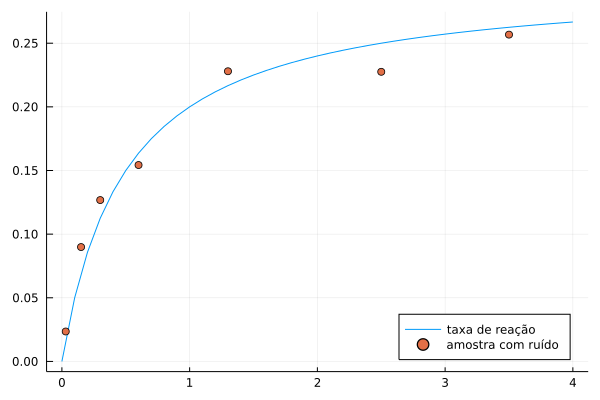

In [3]:
data_t = [0.03, 0.15, 0.3, 0.6, 1.3, 2.5, 3.5]
data_v = model(data_t, p) .+ 0.05*(rand(MersenneTwister(321), length(data_t)) .- 0.5)
plot(0:0.1:4, t -> model(t, p), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")

### Ajuste dos dados via LsqFit

* Otimizando com o `curve_fit` do `LsqFit`

* É necessário dar um "chute" inicial para os parâmetros.

In [4]:
p0 = [0.5, 0.5]
fit = curve_fit(model, data_t, data_v, p0)
p_fit = fit.param

2-element Vector{Float64}:
 0.27385430554237405
 0.3573547044880839

### Visualizando o resultado

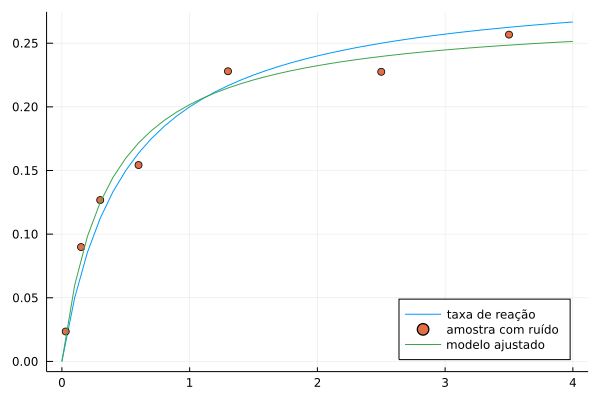

In [5]:
plot(0:0.1:4, t -> model(t, p), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(0:0.1:4, t -> model(t, p_fit), label="modelo ajustado", legend=:bottomright)

### Ajuste dos dados via Optim

* Aqui, usamos o método de gradiente conjugado do `Optim`.

* No `Optim`, precisamos explicitar a função custo.

* Lembremos que queremos ajustar os parâmetros, ou seja, precisamos minimizar o custo em relação aos parâmetros.

In [6]:
custo(p) = sum(abs2,data_v - model(data_t,p))

custo (generic function with 1 method)

In [7]:
resultado = optimize(custo, p0, ConjugateGradient())

 * Status: success

 * Candidate solution
    Minimizer: [2.74e-01, 3.57e-01]
    Minimum:   7.751687e-04

 * Found with
    Algorithm:     Conjugate Gradient
    Initial Point: [5.00e-01, 5.00e-01]

 * Convergence measures
    |x - x'|               = 2.04e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.71e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.74e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.25e-12 ≰ 0.0e+00
    |g(x)|                 = 2.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    11
    f(x) calls:    28
    ∇f(x) calls:   19


In [8]:
p_optim = Optim.minimizer(resultado)

2-element Vector{Float64}:
 0.27385430936829597
 0.357354724661875

### Visualizando o resultado

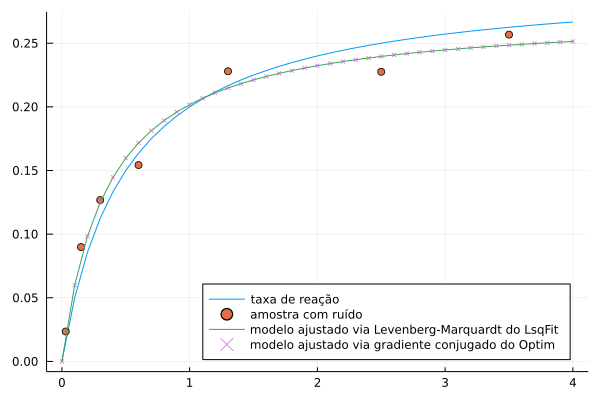

In [9]:
plot(0:0.1:4, t -> model(t, p), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(0:0.1:4, t -> model(t, p_fit), label="modelo ajustado via Levenberg-Marquardt do LsqFit", legend=:bottomright)
plot!(0:0.1:4, t -> model(t, p_optim), seriestype=:scatter, markershape=:xcross, markersize=2,
        label="modelo ajustado via gradiente conjugado do Optim", legend=:bottomright)

## Dados espúrios *(outliers)*

* É comum, por dificuldades no processo de amostragem ou de tratamento dos dados, termos dados "espúrios", i.e. claramente fora do padrão.

* São denominados de *outliers*.

* Podemos tentar filtrar os dados espúrios da amostra usando técnicas de estatística.

* E/Ou podemos reduzir o impacto dos dados espúrios com funções de custo ligeiramente modificadas.

## Exercícios

1. Usando os dados do arquivo `dados/reacao_enzimatica_figado_porco.csv` e métodos de otimização não-linear (sem a transformação para `1/\nu`e `1/S`como feito anteriormente), faça um ajuste dos parâmetros $\nu_m$ e $K_M$ aos dados da ação de uma enzima presente no fígado de porcos de acordo com o modelo de Michaelis-Menten
$$ \nu = \frac{\displaystyle \nu_m S}{\displaystyle K_M + S}, 
$$
onde $\nu_m>0$ é a a taxa máxima de reação (associada a uma concentração muito alta do substrato) e $K_M>0$ é um parâmetro de (semi)saturação. A reação associada a esse processo é da forma $E + S \rightleftharpoons ES \rightarrow E + P$. Compare o  resultado com o método de mínimos quadrados linear feito anteriormente, através da mudança de variáveis mencionada acima.

<!--NAVIGATOR-->

---
[<- 9. Mínimos quadrados não-linear](09.00-Minimos_quadrados_nao_linear.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) 